<a href="https://colab.research.google.com/github/s1111e/ComputerVision/blob/main/FirstImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is my CV Project **

In [ ]:
import torch, platform, os, sys, subprocess, random, shutil, math, json, glob
print("Torch CUDA:", torch.cuda.is_available())

Torch CUDA: True


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
basePath = "/content/drive/My Drive/Colab Notebooks/CV Project/Data/"

In [ ]:
# 3) KITTI Dataset
import os, glob
kitti_root = os.path.join(basePath, "kitti")
kitti_img_dir = os.path.join(kitti_root, "training", "image_2")
kitti_lbl_dir = os.path.join(kitti_root, "training", "label_2")

print("KITTI image dir:", kitti_img_dir)
print("KITTI label dir:", kitti_lbl_dir)
print("Image dir exists?", os.path.isdir(kitti_img_dir))
print("Label dir exists?", os.path.isdir(kitti_lbl_dir))

KITTI image dir: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/image_2
KITTI label dir: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/label_2
Image dir exists? True
Label dir exists? True


In [ ]:

# Extract Folder
os.makedirs(kitti_root, exist_ok=True)

# Zip file path
img_zip = os.path.join(basePath, "data_object_image_2.zip")
lbl_zip = os.path.join(basePath, "data_object_label_2.zip")

print("Image zip exists?", os.path.exists(img_zip))
print("Label zip exists?", os.path.exists(lbl_zip))

Image zip exists? True
Label zip exists? True


In [ ]:
!unzip -q "{img_zip}" -d "{kitti_root}"
!unzip -q "{lbl_zip}" -d "{kitti_root}"

replace /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/image_2/002480.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import glob

img_files = glob.glob(os.path.join(kitti_root, "training", "image_2", "*.png"))
lbl_files = glob.glob(os.path.join(kitti_root, "training", "label_2", "*.txt"))

print("Total Image", len(img_files))
print("Total Label", len(lbl_files))
print("Sample Image:", img_files[0])
print("Sample Label:", lbl_files[0])

Total Image 7481
Total Label 7481
Sample Image: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/image_2/000003.png
Sample Label: /content/drive/My Drive/Colab Notebooks/CV Project/Data/kitti/training/label_2/002445.txt


In [ ]:
import os, cv2, glob, shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Path
basePath = "/content/drive/My Drive/Colab Notebooks/CV Project/Data/"
kitti_root = os.path.join(basePath, "kitti")
kitti_img_dir = os.path.join(kitti_root, "training", "image_2")
kitti_lbl_dir = os.path.join(kitti_root, "training", "label_2")

# YOLO dataset
yolo_root = os.path.join(basePath, "yolo_kitti")
for p in [
    os.path.join(yolo_root, "images", "train"),
    os.path.join(yolo_root, "images", "val"),
    os.path.join(yolo_root, "labels", "train"),
    os.path.join(yolo_root, "labels", "val"),
]:
    os.makedirs(p, exist_ok=True)

# 3-class mapping
keep_classes = {"Car":0, "Pedestrian":1, "Cyclist":2}
ignore_classes = {"Person_sitting","Van","Truck","Tram","Misc","DontCare"}

# subdomain for test
MAX_IMAGES = 1000  # for test

all_imgs = sorted(glob.glob(os.path.join(kitti_img_dir, "*.png")))
if MAX_IMAGES and MAX_IMAGES < len(all_imgs):
    all_imgs = all_imgs[:MAX_IMAGES]

train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

def kitti_line_to_yolo(line, W, H):
    f = line.strip().split()
    if len(f) < 8:
        return None
    cls_name = f[0]
    if cls_name in ignore_classes:
        return None
    if cls_name not in keep_classes:
        return None
    # bbox: left, top, right, bottom
    left, top, right, bottom = map(float, f[4:8])

    # YOLO normalization
    x = (left + right) / 2.0 / W
    y = (top + bottom) / 2.0 / H
    w = (right - left) / W
    h = (bottom - top) / H

    # clip
    x = min(max(x, 0.0), 1.0)
    y = min(max(y, 0.0), 1.0)
    w = min(max(w, 0.0), 1.0)
    h = min(max(h, 0.0), 1.0)
    return keep_classes[cls_name], x, y, w, h

def convert_split(split_imgs, split_name):
    im_out = os.path.join(yolo_root, "images", split_name)
    lb_out = os.path.join(yolo_root, "labels", split_name)

    for img_path in tqdm(split_imgs, desc=f"Convert {split_name}"):
        stem = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(kitti_lbl_dir, f"{stem}.txt")

        img = cv2.imread(img_path)
        if img is None:
            continue
        H, W = img.shape[:2]

        yolo_lines = []
        if os.path.exists(lbl_path):
            with open(lbl_path, "r") as f:
                for line in f:
                    parsed = kitti_line_to_yolo(line, W, H)
                    if parsed is None:
                        continue
                    cid, x, y, w, h = parsed
                    yolo_lines.append(f"{cid} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

        # label file
        with open(os.path.join(lb_out, f"{stem}.txt"), "w") as f:
            f.write("\n".join(yolo_lines))

        # Copy
        shutil.copy(img_path, os.path.join(im_out, os.path.basename(img_path)))

convert_split(train_imgs, "train")
convert_split(val_imgs, "val")

print("Sınıflar:", keep_classes)
print("Train görüntü:", len(train_imgs), " | Val görüntü:", len(val_imgs))
print("YOLO kök dizin:", yolo_root)


Convert val: 100%|██████████| 200/200 [08:31<00:00,  2.56s/it]

Sınıflar: {'Car': 0, 'Pedestrian': 1, 'Cyclist': 2}
Train görüntü: 800  | Val görüntü: 200
YOLO kök dizin: /content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti


In [ ]:
data_yaml_path = os.path.join(basePath, "data_kitti.yaml")
yaml_text = f"""path: {yolo_root}
train: images/train
val: images/val

names:
  0: Car
  1: Pedestrian
  2: Cyclist
"""
with open(data_yaml_path, "w") as f:
    f.write(yaml_text)

print(open(data_yaml_path).read())


path: /content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti
train: images/train
val: images/val

names:
  0: Car
  1: Pedestrian
  2: Cyclist



In [ ]:
!pip -q install -U ultralytics

from ultralytics import YOLO
import torch

print("CUDA:", torch.cuda.is_available())
model = YOLO("yolo11n.pt")  # for quick start

model.train(
    data=data_yaml_path,
    epochs=20,        # for training
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else "cpu"
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CUDA: True
Ultralytics 8.3.208 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/Colab Notebooks/CV Project/Data/data_kitti.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, forma

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a2eb4f8daf0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Ultralytics 8.3.208 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 211.1±84.6 MB/s, size: 816.4 KB)
val: Scanning /content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 2.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.5it/s 3.7s
                   all        200        969      0.739      0.509      0.575      0.339
                   Car        182        829      0.834      0.776      0.856      0.603
            Pedestrian         46        104      0.767      0.474      0.579      0.258
               Cyclist         25         36      0.616      0.278      0.291      0.157
Speed: 1.0ms preprocess, 3.6ms inference, 0.0ms loss, 3.0ms postprocess per image
Results

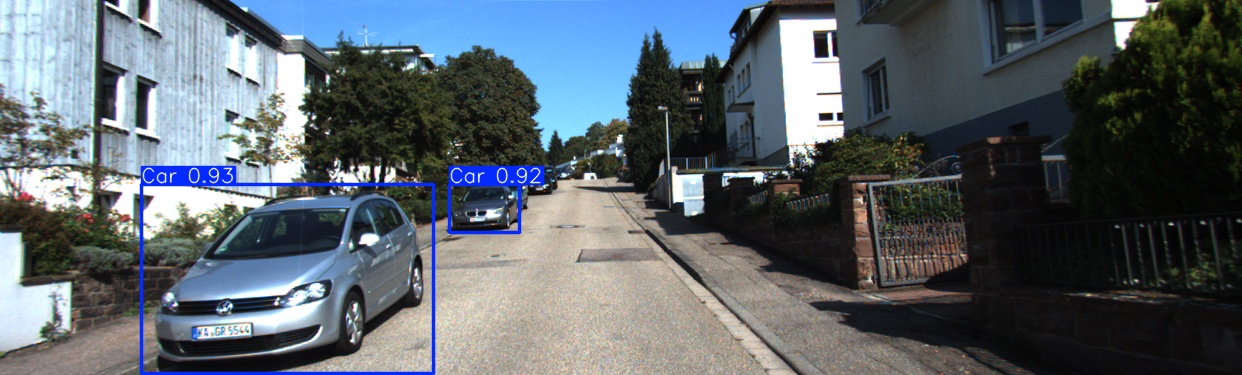

In [ ]:
# mAP
!yolo val model=runs/detect/train/weights/best.pt data="{data_yaml_path}"

# random image test
import glob, random, IPython
val_imgs = glob.glob(os.path.join(yolo_root, "images", "val", "*.png"))
sample = random.choice(val_imgs)
print("Sample:", sample)

!yolo predict model=runs/detect/train/weights/best.pt source="{sample}" save=True

# show result
pred_dir_candidates = sorted(glob.glob("runs/detect/predict*"))
pred_dir = pred_dir_candidates[-1]
pred_imgs = glob.glob(os.path.join(pred_dir, "*.png")) + glob.glob(os.path.join(pred_dir, "*.jpg"))
IPython.display.Image(pred_imgs[0])


In [ ]:
!yolo val model=/content/runs/detect/train/weights/best.pt data="/content/drive/My Drive/Colab Notebooks/CV Project/Data/data_kitti.yaml" plots=True


Ultralytics 8.3.208 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 233.2±82.6 MB/s, size: 806.5 KB)
val: Scanning /content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/labels/val.cache... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 2.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 13/13 3.7it/s 3.5s
                   all        200        969      0.739      0.509      0.575      0.339
                   Car        182        829      0.834      0.776      0.856      0.603
            Pedestrian         46        104      0.767      0.474      0.579      0.258
               Cyclist         25         36      0.616      0.278      0.291      0.157
Speed: 0.9ms preprocess, 3.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results

Seçilen örnek sayısı: 8
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000408.png
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000548.png
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000902.png
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000462.png
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000254.png
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000445.png
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000298.png
/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000327.png
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/1 /content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti/images/val/000408.pn

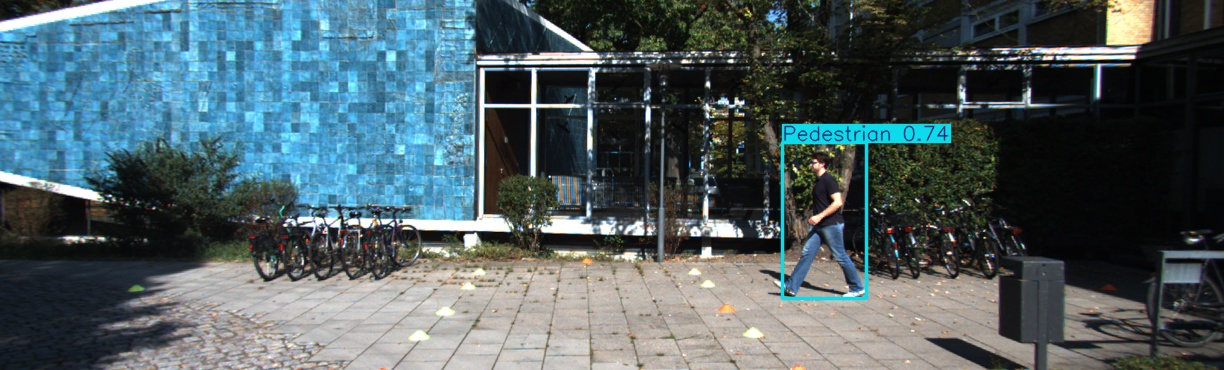

In [ ]:
import os, glob, random, re, IPython

yolo_root = "/content/drive/My Drive/Colab Notebooks/CV Project/Data/yolo_kitti"
val_img_dir = f"{yolo_root}/images/val"
val_lbl_dir = f"{yolo_root}/labels/val"

# Pedestrian(1) or Cyclist(2) images
cand = []
for lbl in glob.glob(f"{val_lbl_dir}/*.txt"):
    txt = open(lbl).read()
    if re.search(r"^(1|2)\s", txt, flags=re.M):  # find
        stem = os.path.basename(lbl).split(".")[0]
        imgp = os.path.join(val_img_dir, stem + ".png")
        if os.path.exists(imgp):
            cand.append(imgp)

random.shuffle(cand)
subset = cand[:8] if len(cand) > 8 else cand
print("Seçilen örnek sayısı:", len(subset))
for s in subset:
    print(s)

# estimate this subset
for s in subset:
    !yolo predict model=/content/runs/detect/train/weights/best.pt source="{s}" save=True

pred_dir = sorted(glob.glob("runs/detect/predict*"))[-1]
print("Predictions:", pred_dir)
# show random
imgs = glob.glob(os.path.join(pred_dir, "*.png")) + glob.glob(os.path.join(pred_dir, "*.jpg"))
IPython.display.Image(random.choice(imgs)) if imgs else print("No images found.")


Car: n=829, median area=0.00847, 25p=0.00316, 75p=0.02797


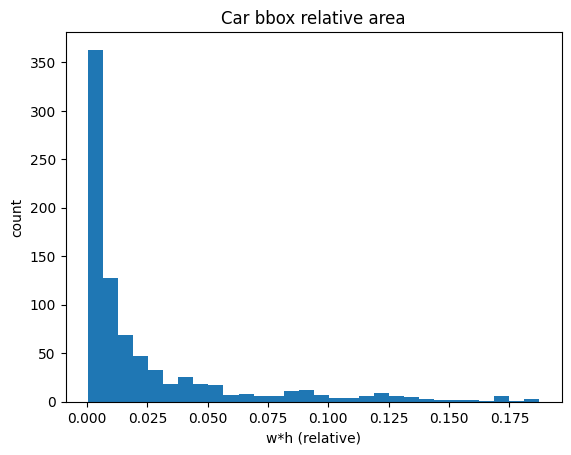

Pedestrian: n=104, median area=0.00723, 25p=0.00279, 75p=0.01767


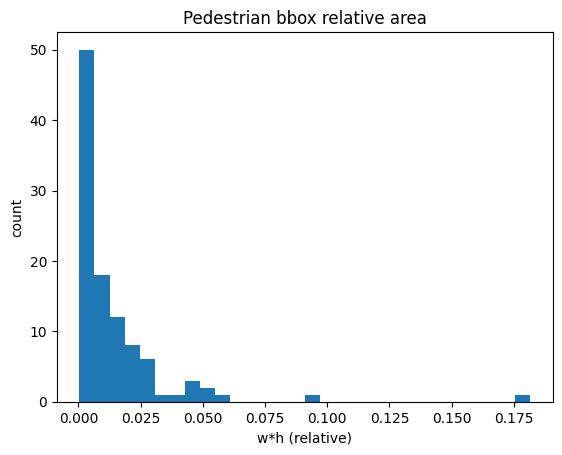

Cyclist: n=36, median area=0.00208, 25p=0.00107, 75p=0.01325


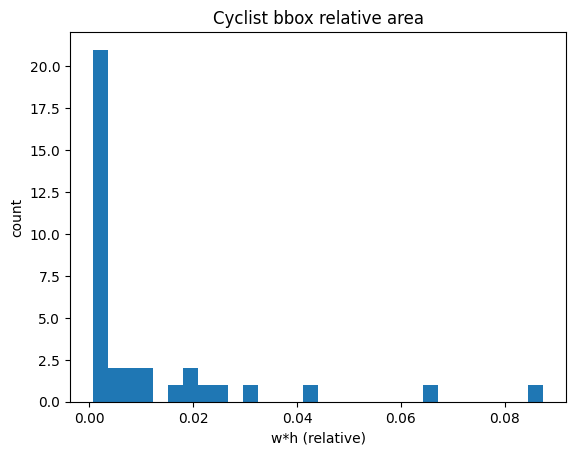

In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

val_img_dir = f"{yolo_root}/images/val"
val_lbl_dir = f"{yolo_root}/labels/val"

areas = {0:[],1:[],2:[]}
for lbl in glob.glob(f"{val_lbl_dir}/*.txt"):
    stem = os.path.basename(lbl).split(".")[0]
    imgp = os.path.join(val_img_dir, stem + ".png")
    if not os.path.exists(imgp):
        continue
    #
    from PIL import Image
    W,H = Image.open(imgp).size
    for line in open(lbl):
        f = line.strip().split()
        if len(f) != 5:
            continue
        cid = int(f[0]); x,y,w,h = map(float, f[1:])
        areas[cid].append(w*h)  #

for cid,name in {0:"Car",1:"Pedestrian",2:"Cyclist"}.items():
    a = np.array(areas[cid])
    if a.size:
        print(f"{name}: n={a.size}, median area={np.median(a):.5f}, 25p={np.percentile(a,25):.5f}, 75p={np.percentile(a,75):.5f}")
        plt.figure()
        plt.hist(a, bins=30)
        plt.title(f"{name} bbox relative area")
        plt.xlabel("w*h (relative)"); plt.ylabel("count")
        plt.show()
